# 초기 세팅

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [37]:
from torchsummary import summary

- 현재 GPU 설정

In [38]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [40]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [41]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=CIFAR_transform)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
# DataLoader

batch_size = 4

train_loader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_loader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [43]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

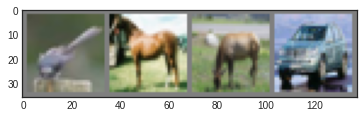

bird	 horse	 deer	 car	


In [44]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

**<구조>** <br>
[Feature Extraction] Conv1 -> MaxPooling -> Conv2 -> Conv3 -> Conv4 <br>
[Classification] fc1 -> fc2 <br>
activating function : ReLU (마지막 fc2 제외)

In [66]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=1)
      # in_channels = 3 : 컬러
      # out_channels = 6
      # (32 - 5 + 2*1)/1 +1 = 30 = n

      # maxpool : n=30 -> 15  / 코드 : F.max_pool2d(x, (2,2))

      self.conv2 = nn.Conv2d(in_channels=6, out_channels=5, kernel_size=3, stride=2, padding=2)
      # (15 - 3 +2*2)/2 +1 = 9 = n

      self.conv3 = nn.Conv2d(in_channels=5, out_channels=8, kernel_size=3, stride=2, padding=1)
      # (9 - 3 + 2*1)/2 +1 = 5 = n

      self.fc1 = nn.Linear(8*5*5, 80)
      self.fc2 = nn.Linear(80, 10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(-1, self.num_flat_features(x)) # num_flat_features : 아래에서 정의

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


    def num_flat_features(self, x): # 처음 dim-size을 제외하고, 모두 곱한 값을 반환해준다.
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [67]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 5, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(5, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=200, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)

In [68]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [69]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [70]:
# 모델 구조 확인

summary(myNet, input_size=(3, 32, 32), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 6, 30, 30]             456
            Conv2d-2             [128, 5, 9, 9]             275
            Conv2d-3             [128, 8, 5, 5]             368
            Linear-4                  [128, 80]          16,080
            Linear-5                  [128, 10]             810
Total params: 17,989
Trainable params: 17,989
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.50
Forward/backward pass size (MB): 5.95
Params size (MB): 0.07
Estimated Total Size (MB): 7.52
----------------------------------------------------------------


## 손실함수와 옵티마이저

In [71]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [72]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()                      # 가중치 초기화

        outputs = myNet(inputs)                    # y_pred
        loss = criterion(outputs, labels)          # 손실함수를 이용해서 loss계산
        loss.backward()                            # back-propagation
        optimizer.step()                           # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 2.2657100550532343
Epoch: 1, Batch: 4000, Loss: 1.9948438594341278
Epoch: 1, Batch: 6000, Loss: 1.7989167921841145
Epoch: 1, Batch: 8000, Loss: 1.686532560184598
Epoch: 1, Batch: 10000, Loss: 1.6535819034278392
Epoch: 1, Batch: 12000, Loss: 1.6076055511683225
Epoch: 2, Batch: 2000, Loss: 1.552969237744808
Epoch: 2, Batch: 4000, Loss: 1.5396721648573874
Epoch: 2, Batch: 6000, Loss: 1.5210885545313357
Epoch: 2, Batch: 8000, Loss: 1.4875274272412062
Epoch: 2, Batch: 10000, Loss: 1.4584568730145693
Epoch: 2, Batch: 12000, Loss: 1.4452632185742258
Epoch: 3, Batch: 2000, Loss: 1.3918065634220838
Epoch: 3, Batch: 4000, Loss: 1.368795315347612
Epoch: 3, Batch: 6000, Loss: 1.385328540764749
Epoch: 3, Batch: 8000, Loss: 1.3705753709375859
Epoch: 3, Batch: 10000, Loss: 1.3396225344985724
Epoch: 3, Batch: 12000, Loss: 1.3553099937289954
Epoch: 4, Batch: 2000, Loss: 1.3080419851019978
Epoch: 4, Batch: 4000, Loss: 1.296118002615869
Epoch: 4, Batch: 6000, Loss: 1.31607520

## 모델의 저장 및 로드

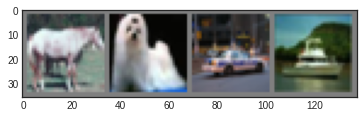

	horse 	dog 	car 	ship


In [73]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [74]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [75]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [76]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)          # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = myNet(images)                           # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print("Accuracy of this model : {}%".format(100 * correct / total))

Accuracy of this model : 60.834%


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [77]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): 
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 59.48%
Accuracy of car: 79.96%
Accuracy of bird: 63.72%
Accuracy of cat: 29.94%
Accuracy of deer: 54.28%
Accuracy of dog: 47.28%
Accuracy of frog: 72.62%
Accuracy of horse: 64.98%
Accuracy of ship: 64.64%
Accuracy of truck: 71.44%
